# Predicting housing prices using linear regression

We are using linear regression in order to predict housing prices from an example Kaggle dataset.

This is a part of the [ML Zoomcamp](https://github.com/DataTalksClub/machine-learning-zoomcamp/), a guided set of tutorials on teaching machine learning.

Source: https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/02-regression/homework.md


In [1]:
# we grab the data 
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-12-22 16:29:37--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  2.14MB/s    in 0.6s    

2023-12-22 16:29:38 (2.14 MB/s) - ‘housing.csv’ saved [1423529/1423529]



Let's get our data loaded as well as import any necessary packages


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [25]:
df = pd.read_csv("housing.csv")

Just taking a peek at the data that we have:


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Exploratory data

Before we start doing any machine learning, we should take a look at the data that we have, so that we can get a general sense of what we're working with.


We want to predict the `median_house_value` column, so let's pull that from our dataset and just see how it looks


<Axes: xlabel='median_house_value', ylabel='Count'>

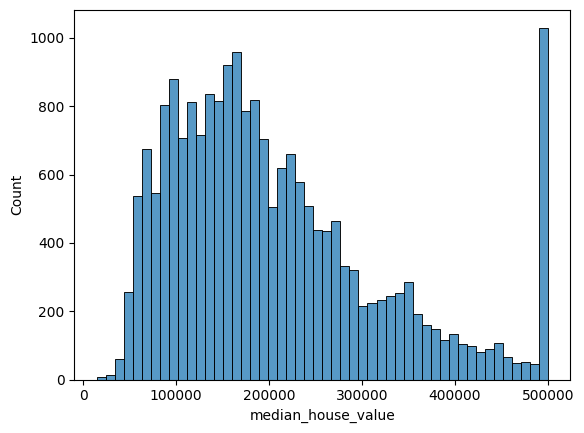

In [26]:
sns.histplot(df["median_house_value"], bins=50)

It looks like the distribution has a heavy right skew. The large number of values at 500,000 is likely a matter of coding, where anything >$500,000 was just coded as 500,000.

Let's remove these from our dataset as we don't want those arbitrarily coded values to affect our dataset (plus, 500,000 isn't actually what they were sold for, so if we keep them then we're doing a classification problem instead of a regression problem).

We also generally dislike skew in our output variables. Although we don't explicitly need a normal distribution for our output variable, linear regression does assume that the residuals are normally distributed (see [here](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/normality/) for an explanation). If our outcome variable $$Y$$ is too skewed, then it becomes more unlikely that our residuals are normally distributed, and for our residuals to be closer to normally distributed our regression outline would have to be pulled in the direction of our skew, which increases the errors on the majority of our distribution.

To resolve this, we can do a log transformation of our output variable (see [here](https://onlinestatbook.com/2/transformations/log.html) for an explanation). The log transform reduces skewness and brings values closer to the center of the distribution. We can do this using `np.log1p` (we use the `1p` since we can't take a log of a zero, so using 1p prevents that problem). We will use this transformed variable as our output $$Y$$ and then exponentiate it (using `np.exp1m`) to get our predictions.

*Note: the more transformations that we do on our dataset, the less interpretable our results are going to be (even though it is a linear regression). We need to keep this in mind when making our modeling choices - do we want to prioritize performance at the cost of simplicity and explainability. Notably, a linear regression is probably the most explainable ML algorithm, but as we have the option to choose other ML algorithms we need to also consider this explainability vs. black box tradeoff as well.*

So, in short, we will:
1. Remove all the rows whose `median_house_value` was coded as the maximum value of 500,000 (we might lose some homes that actually were 500,000, but the vast majority are homes that were priced at >500,000) (note: if we wanted to account for the homes that were >500,000, we could build a second model, a classification model, that determines if a home was sold for =<500,000 or >500,000).
2. Perform a log transformation on the y-values in order to reduce skew.


In [46]:
max_house_value = df["median_house_value"].max()

In [47]:
num_max_coded_rows = len(
    [
        val for val in df["median_house_value"].values
        if val == max_house_value
    ]
)

In [48]:
print(f"Number of rows with max value that we will be removing: {num_max_coded_rows}")
print(f"Dataframe length before filtering: {len(df)}")

Number of rows with max value that we will be removing: 965
Dataframe length before filtering: 20640


In [49]:
# exclude all rows where median_house_value is equal to the max value
df = df[df["median_house_value"] != max_house_value]

In [50]:
print(f"Dataframe length after filtering: {len(df)}")

Dataframe length after filtering: 19675


Let's take a look at the distribution after removing the 500,000+ values:

<Axes: xlabel='median_house_value', ylabel='Count'>

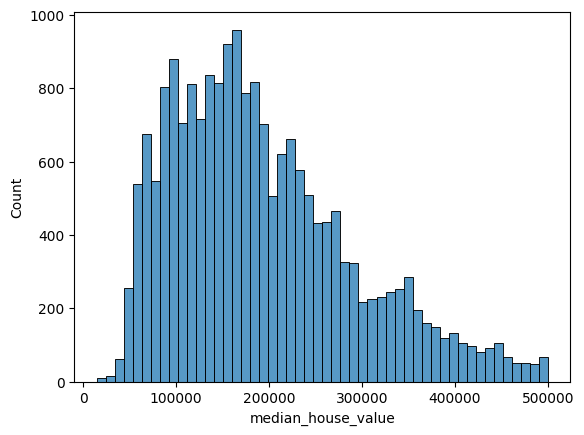

In [51]:
sns.histplot(df["median_house_value"], bins=50)

Now the spike in the values after 500,000 is gone, but there is still a right skew. Let's log-transform the y-values in order to fix this.

In [54]:
median_housing_values = df["median_house_value"]
y = np.log1p(df["median_house_value"])

<Axes: xlabel='median_house_value', ylabel='Count'>

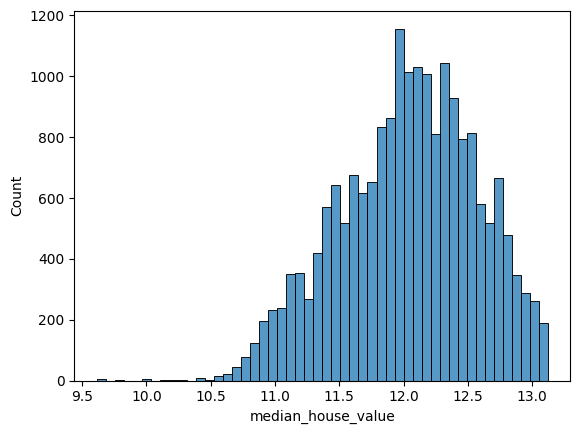

In [53]:
sns.histplot(y, bins=50)

This still has some skew, but it is a big improvement over our previous output variable. The lower the skewness of the underlying distribution, the more likely it is that the residuals will actually follow a normal distribution, which is a fundamental assumption of regression.

In [55]:
del df["median_house_value"]

For our problem, let's take a look at only the properties that are not right on the water, but are some distance away. Since this is a linear regression problem, let's also just look at the columns that are numeric and might have some relationship with the median home price.

In [56]:
property_types = ["<1H OCEAN", "INLAND"]
X = df[df['ocean_proximity'].isin(property_types)]
columns = [
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households", 
    "median_income"
]

X = X[columns]

Let's take a look at our dataset now and see what we can learn:

In [57]:
X.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
701,32.0,1283.0,194.0,485.0,171.0,6.0574
830,9.0,3666.0,711.0,2341.0,703.0,4.6458
859,21.0,4342.0,783.0,2172.0,789.0,4.6146
860,15.0,3575.0,597.0,1777.0,559.0,5.7192
861,20.0,4126.0,1031.0,2079.0,975.0,3.6832


When doing exploratory data analysis, some of the things that we want to look for include:

1. Missing data: do we have any data that is missing? If so, can we impute the missing data?
2. Correlations: are any of the features correlated to each other? If so, can we eliminate redundant features?
3. Normality: 
4: Scaling: 

Let's do these in steps.

#### Normality

#### Correlations

We want features that are generally not really correlated with each other. Conceptually, this is because we want each feature used in our prediction to add more information that will help us make a better prediction.

*Note: mathematically, we need features that aren't correlated - the problem of correlated features, also known as multicollinearity, makes the linear regression problem more difficult, see [here](https://markptorres.com/machine_learning/notes-linear-regression) for more information*

Let's take a look at the correlations between our features:

Let's take a look at the correlations of our features

<Axes: >

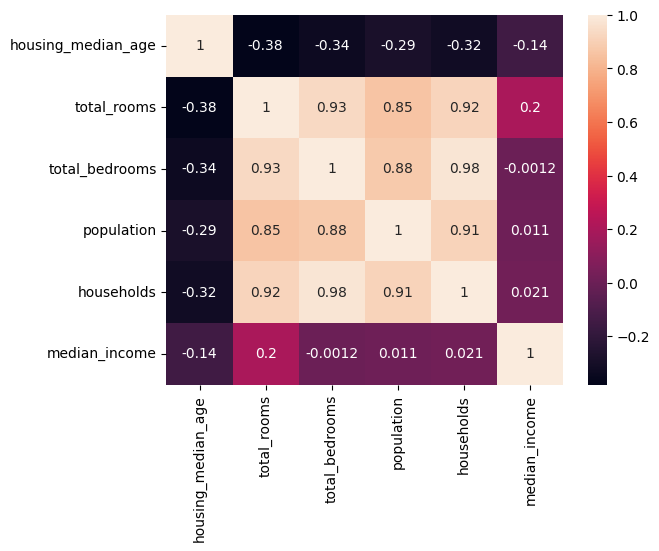

In [23]:
sns.heatmap(X.corr(), annot=True)

As we can see here, the `total_rooms`, `total_bedrooms`, `population`, and `households` are really highly correlated with each other. If we think about it, this makes sense - the larger the population, the more households there are. The more households there are, the more total bedrooms there are, and the more total bedrooms there are, the more total rooms there are.

#### Missing data

#### Scaling

In [ ]:
for col in columns:
    sns.histplot(X[col], bins=50)
    plt.show()